In [1]:
import time
import os
import copy
import cv2
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import shutil
import pandas as pd
import PIL.Image as Image
import torch
import torch.optim as optim
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from __future__ import print_function, division
from sklearn.model_selection import KFold
from pathlib import Path
from tqdm import tqdm
from pylab import rcParams
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
from torchsummary import summary
from collections import defaultdict
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette=sns.color_palette(["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]), font_scale=1.2)
rcParams['figure.figsize'] = [12, 8]
np.random.seed(42);
torch.manual_seed(42);
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
img_size = []
# Data augmentation and normalization for training
# Just normalization for validation

T=transforms;

data_transforms = {'train': T.Compose([
  transforms.Resize((200, 200)),
  T.ToTensor(),
]), 'val': T.Compose([
  transforms.Resize((200, 200)),
  T.ToTensor()
]), 'test': T.Compose([
  transforms.Resize((200, 200)),
  T.ToTensor()
]),
}

data_dir = '/content/drive/MyDrive/ColabAI/classfinal'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['mda', 'u937']


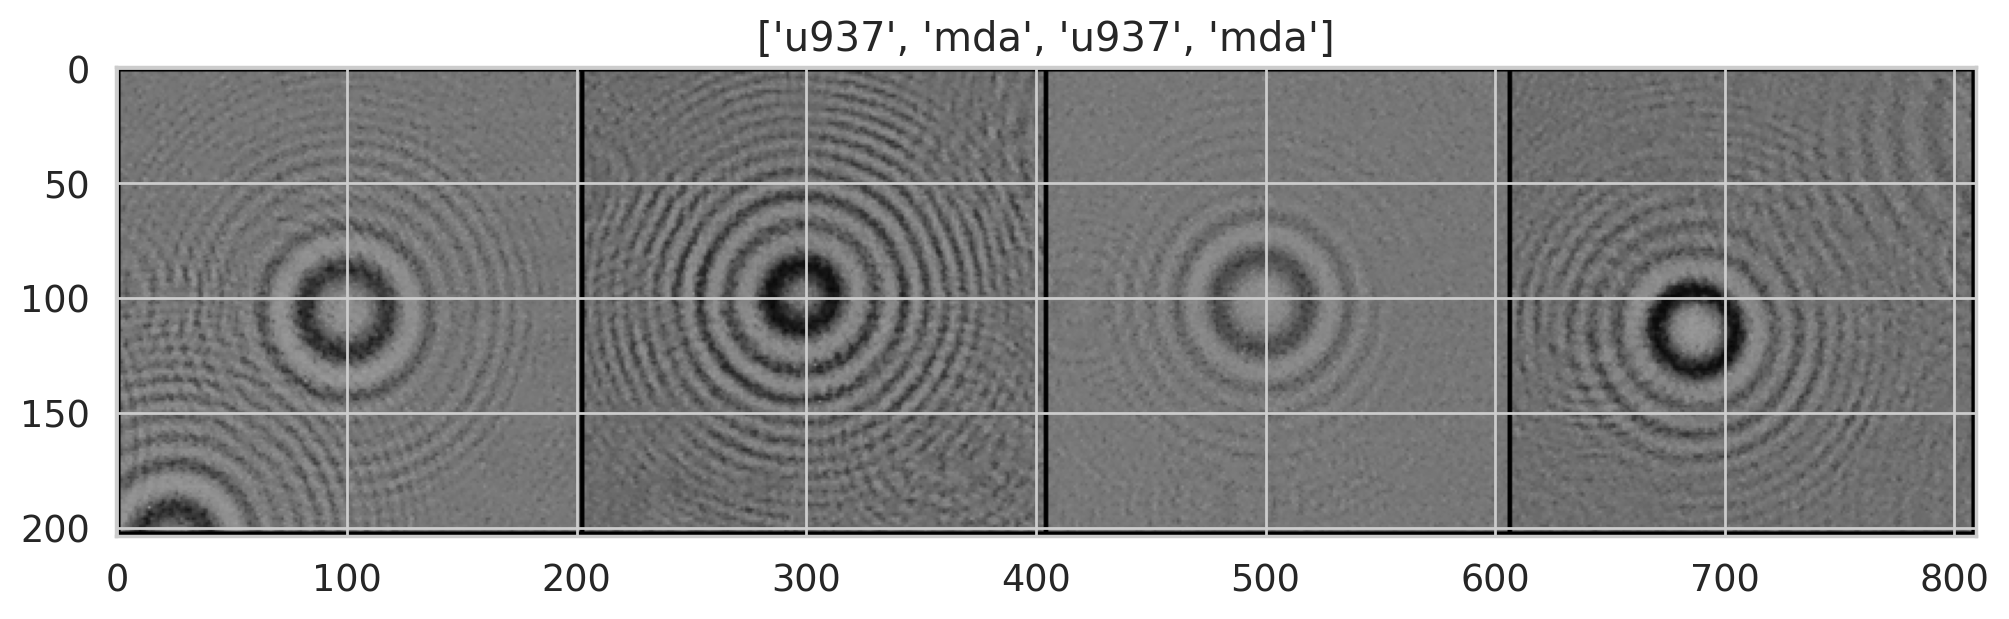

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
   #  mean = np.array([0.229, 0.229, 0.229])
    # std = np.array([0.229, 0.229, 0.229])
   #  inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True)

  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

In [7]:
base_model = create_model(len(class_names))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [9]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [10]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=10):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

In [11]:
#print(base_model)
#summary(base_model, (3, 224, 224),32)

In [12]:
%%time

base_model, history = train_model(base_model, dataloaders, dataset_sizes, device)

Epoch 1/10
----------
Train loss 0.6146316504471341 accuracy 0.7699652777777778
Val   loss 0.3535267443543202 accuracy 0.8355263157894737

Epoch 2/10
----------
Train loss 0.5413780208376314 accuracy 0.8029513888888888
Val   loss 0.6328498812661948 accuracy 0.8092105263157894

Epoch 3/10
----------
Train loss 0.3892951119729939 accuracy 0.8524305555555555
Val   loss 0.5191471038639353 accuracy 0.8552631578947368

Epoch 4/10
----------
Train loss 0.3617073447805726 accuracy 0.8663194444444444
Val   loss 0.7054103734454226 accuracy 0.7236842105263157

Epoch 5/10
----------
Train loss 0.28403767493364285 accuracy 0.9010416666666666
Val   loss 0.27553371485402367 accuracy 0.9013157894736842

Epoch 6/10
----------
Train loss 0.24460856320405988 accuracy 0.9071180555555555
Val   loss 1.7170752784654244 accuracy 0.6184210526315789

Epoch 7/10
----------
Train loss 0.2552681807741869 accuracy 0.9088541666666666
Val   loss 0.191400881171974 accuracy 0.9342105263157894

Epoch 8/10
----------
Tra

In [13]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

#plot_training_history(history)

In [14]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

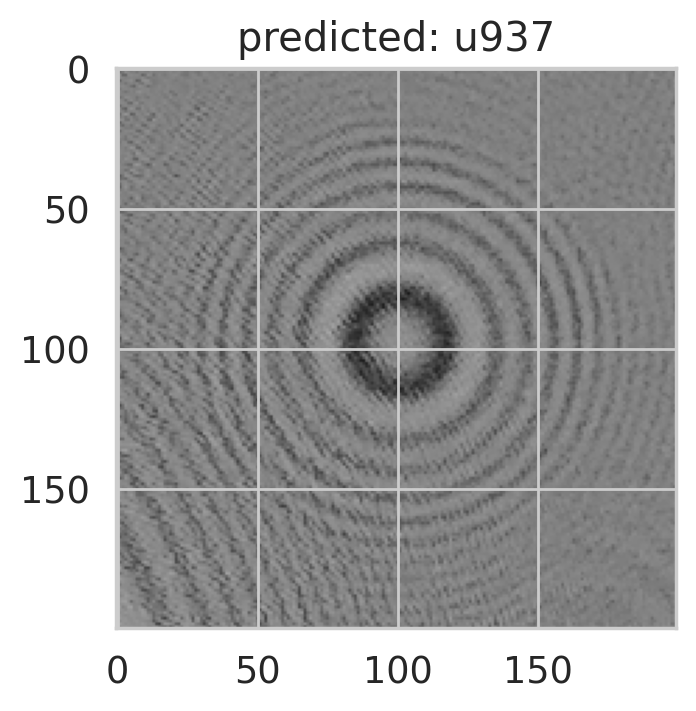

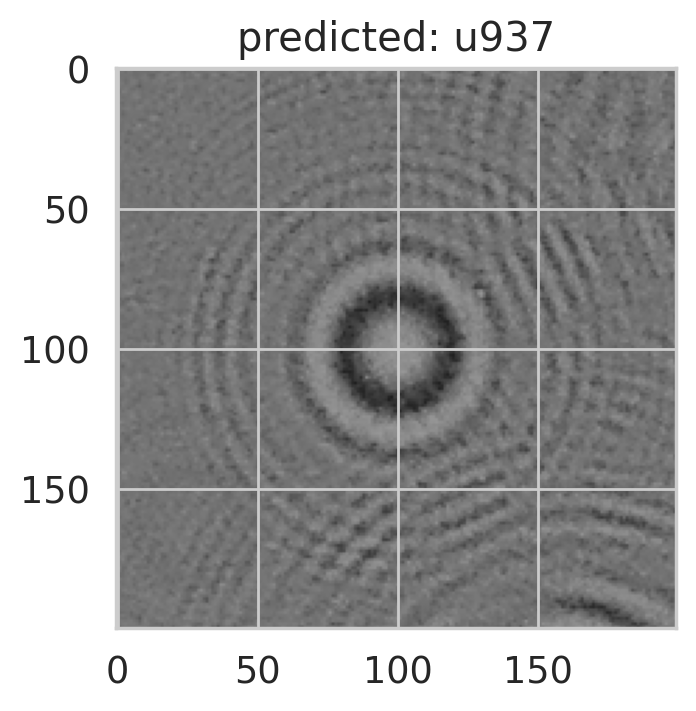

In [15]:
show_predictions(base_model, class_names, n_images=2)

In [16]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [17]:
y_pred, y_test = get_predictions(base_model, dataloaders['test'])

In [18]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         mda       1.00      0.89      0.94        76
        u937       0.90      1.00      0.95        76

    accuracy                           0.95       152
   macro avg       0.95      0.95      0.95       152
weighted avg       0.95      0.95      0.95       152



In [19]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

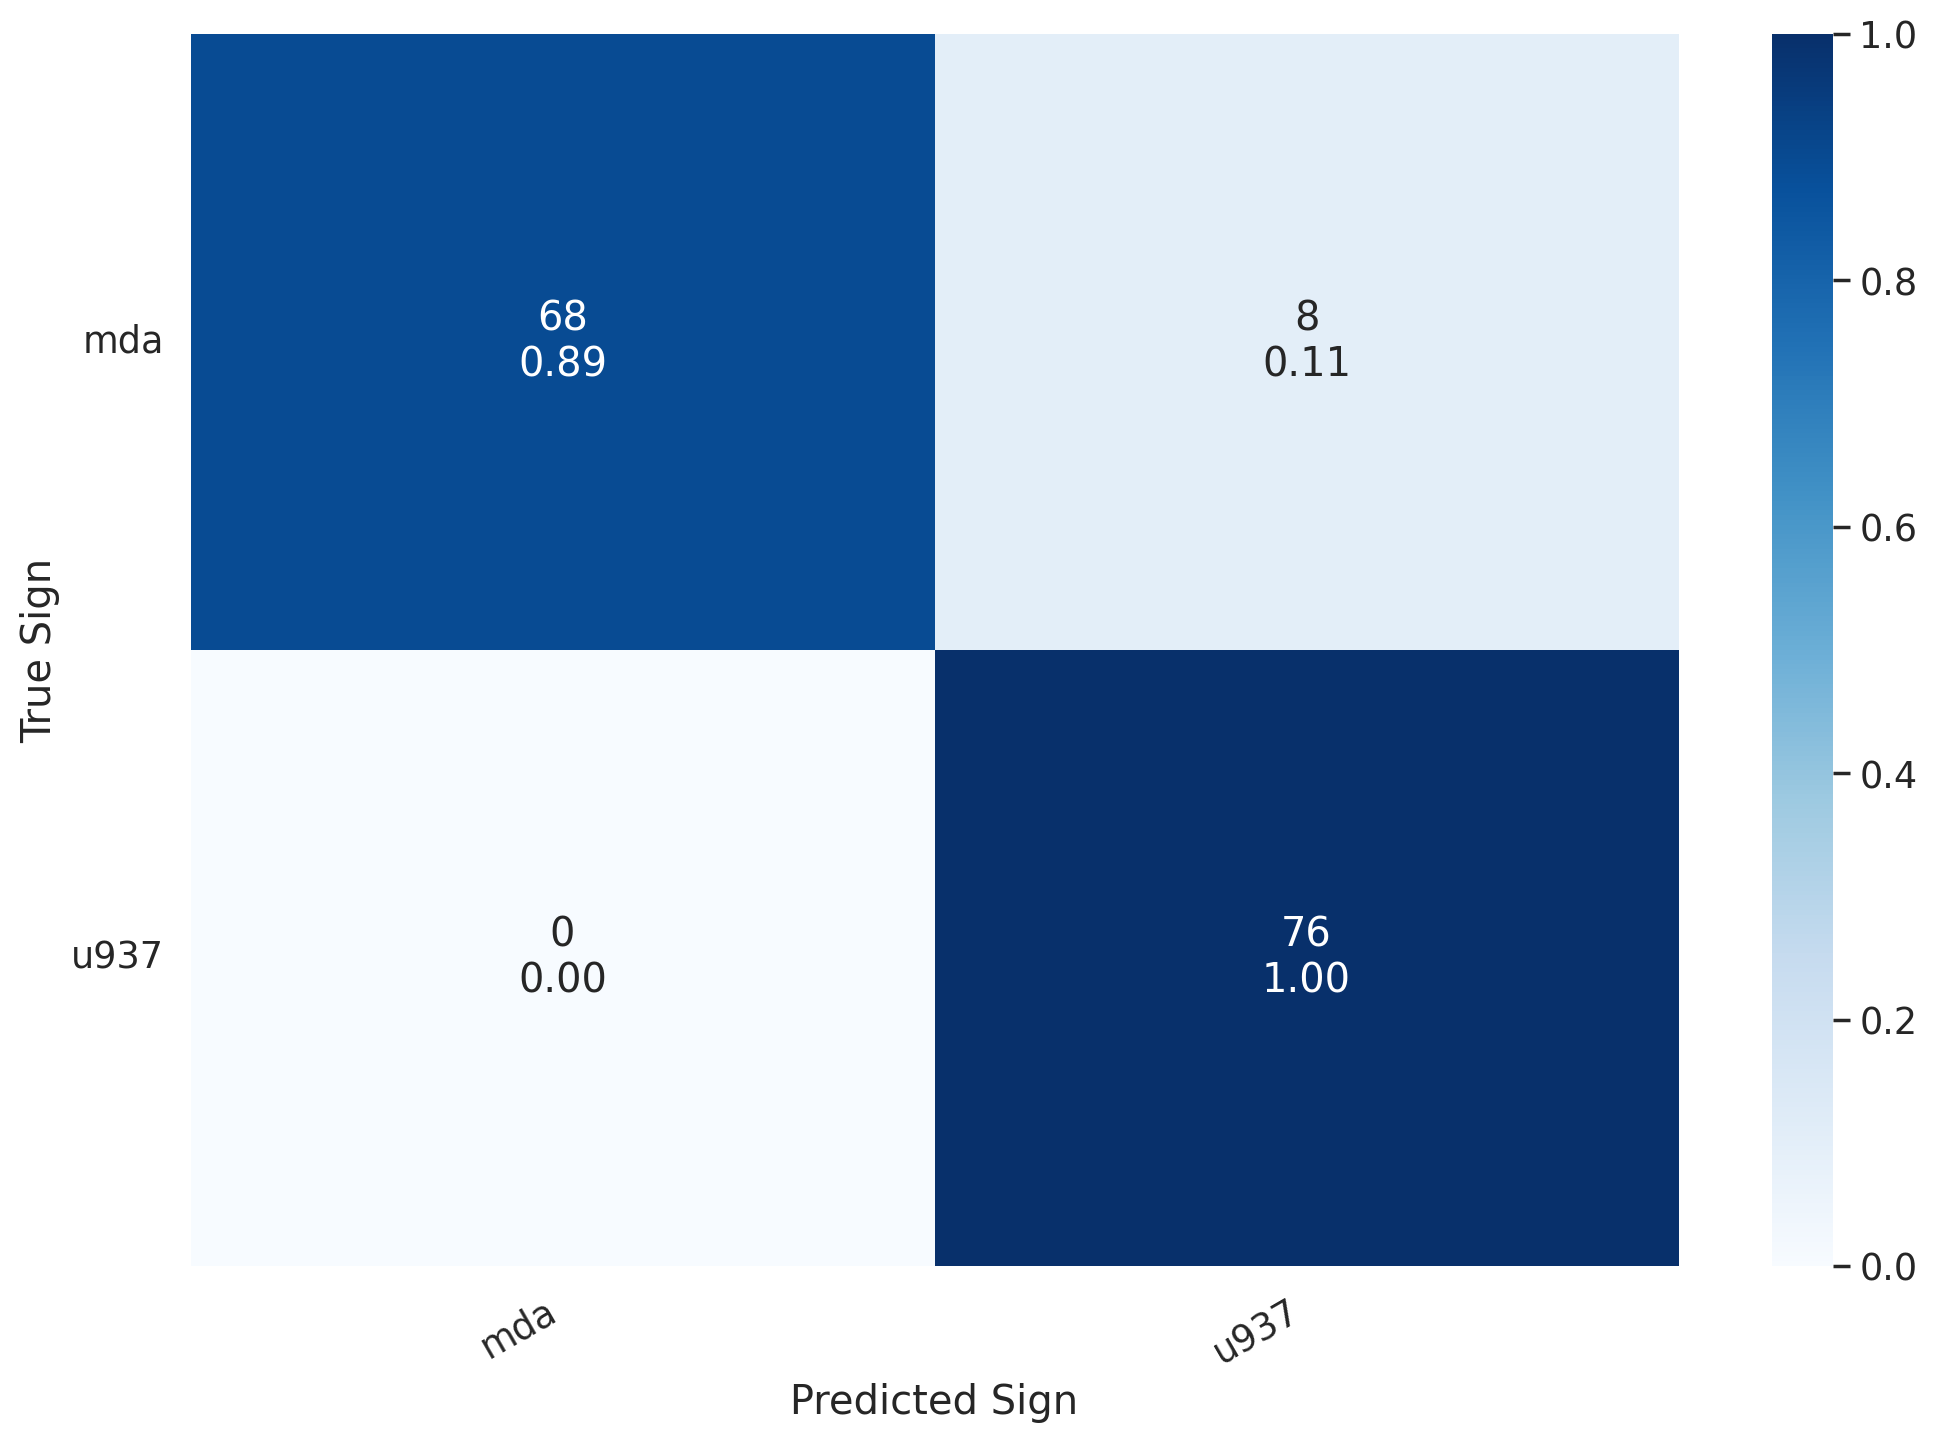

In [20]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

In [21]:
#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  68
False Positives:  8
False Negatives:  0
True Positives:  76


In [22]:
x = y_test
x_np = x.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('ytestf.csv')
from google.colab import files
files.download("ytestf.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
x = y_pred
x_np = x.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('ypredf.csv')
from google.colab import files
files.download("ypredf.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>